# Relativistic MCMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import pandas as pd

import pints
import pints.plot
import pints.toy
import pints.functionaltests.relativistic_mcmc as relativistic

from utils import run_replicates, ecdf_norm_plotter

# Two dimensional Gaussian

In [2]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10,
                      relativistic.two_dim_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

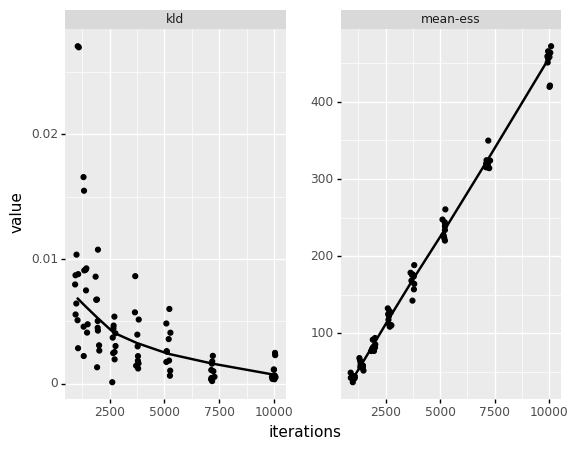

<ggplot: (8793838457287)>

In [3]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

Show example run results.

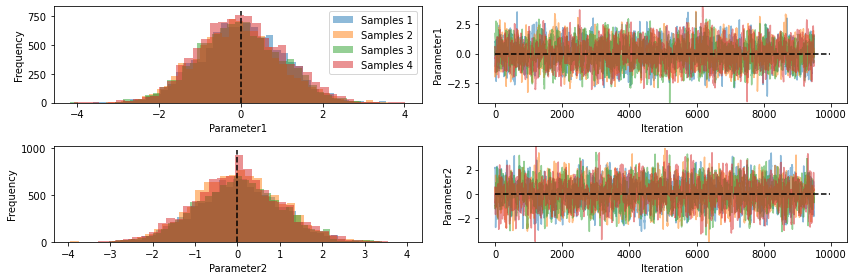

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.02   1.01    -1.95   -0.71  -0.04  0.67   1.98     1.00    1639.02  41.08
param 2  0.02    1.00    -1.92   -0.65  0.02   0.69   2.01     1.00    1863.17  46.70


In [4]:
n_chains = 4
n_iterations = 10000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

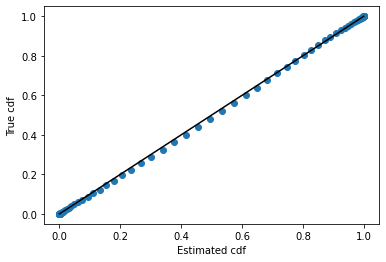

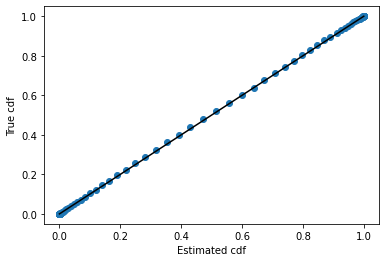

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.correlated_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

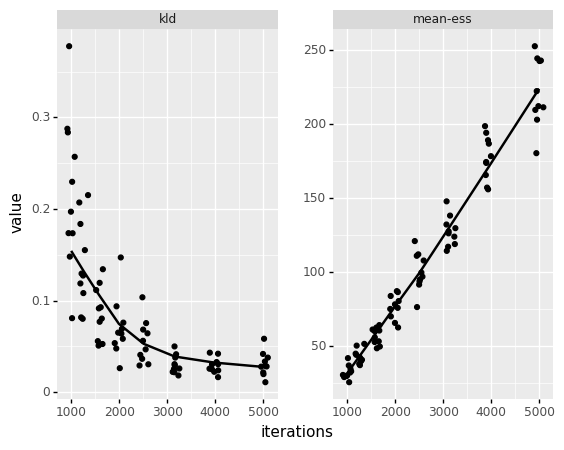

<ggplot: (8793837462104)>

In [7]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results, with a large number of iterations. With this number of iterations, we would expect the CDFs to look accurate.

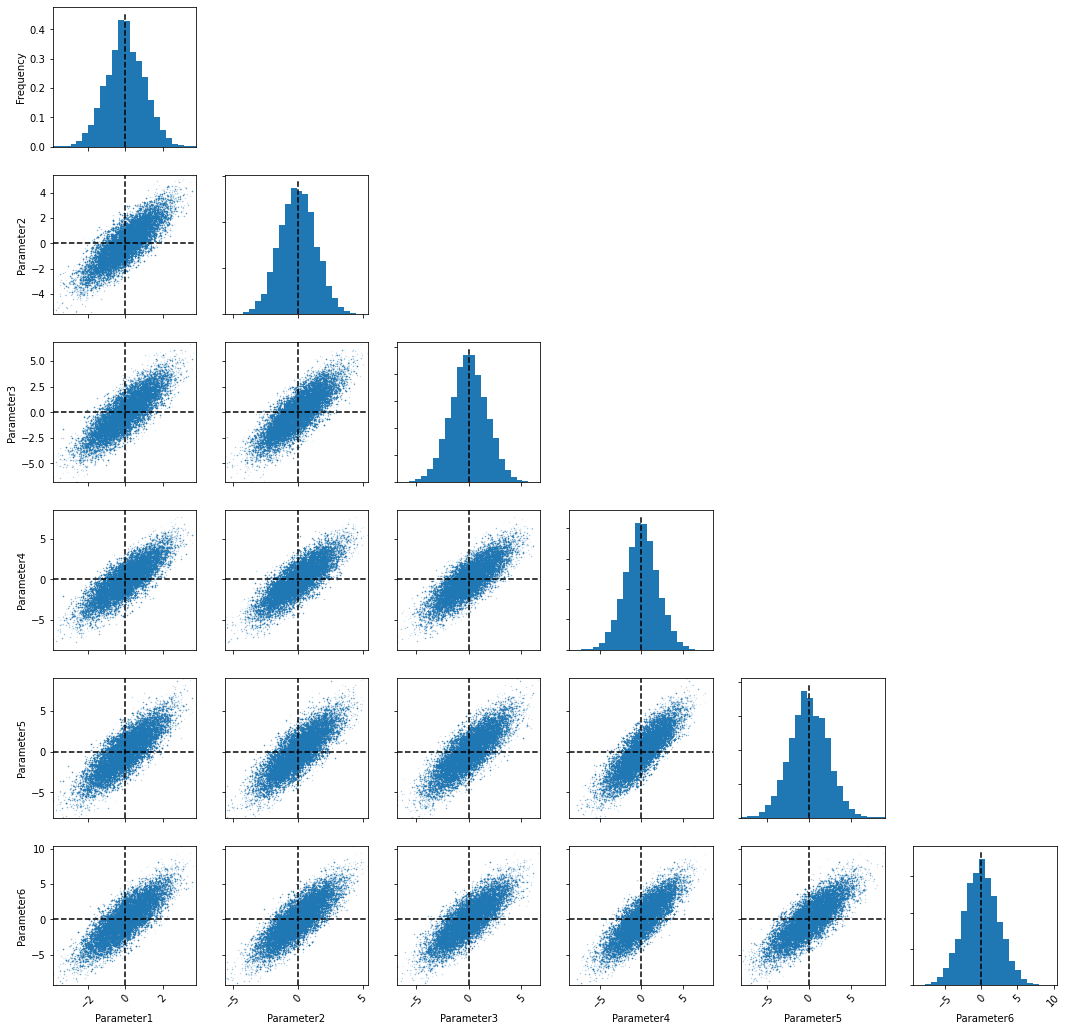

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.02    0.99    -1.96   -0.63  0.01   0.70   1.96     1.00    3266.37  40.77
param 2  0.00    1.41    -2.75   -0.97  -0.01  0.96   2.75     1.00    4801.74  59.93
param 3  -0.01   1.71    -3.38   -1.14  -0.02  1.13   3.35     1.00    4622.68  57.69
param 4  -0.03   1.97    -3.92   -1.33  -0.04  1.24   3.84     1.00    2679.73  33.44
param 5  -0.01   2.21    -4.35   -1.49  -0.06  1.52   4.28     1.00    3220.25  40.19
param 6  -0.00   2.42    -4.76   -1.63  -0.06  1.63   4.74     1.00    4154.37  51.85


In [8]:
n_chains = 4
n_iterations = 20000
n_warmup = 500

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

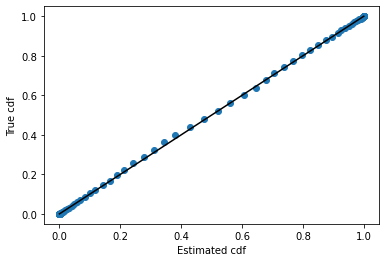

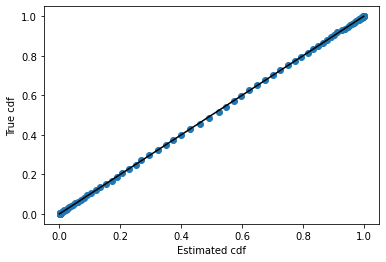

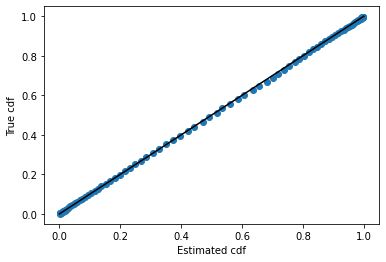

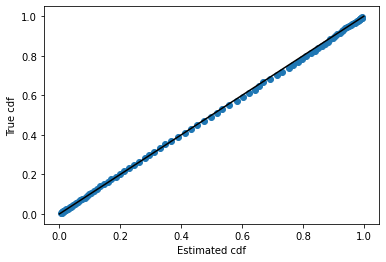

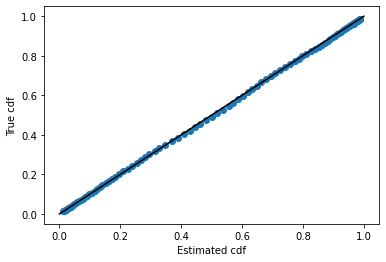

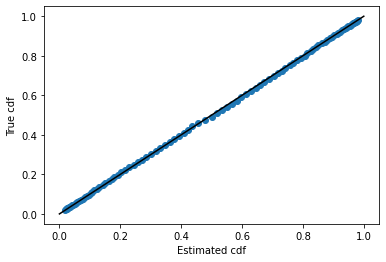

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10, relativistic.banana, parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

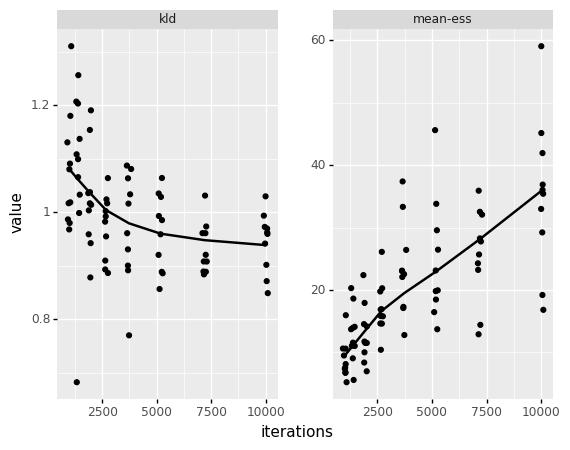

<ggplot: (8793821130183)>

In [11]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The banana is a hard problem, with poor ESS and KLD values, but somewhat reasonable trends.

Example run of results.

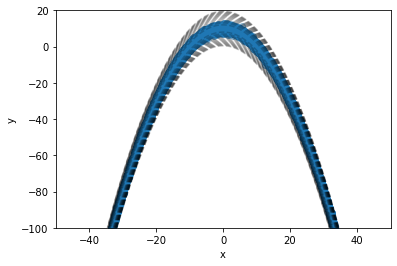

In [12]:
n_chains = 4
n_iterations = 20000
n_warmup = 500

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10,
                      relativistic.annulus,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

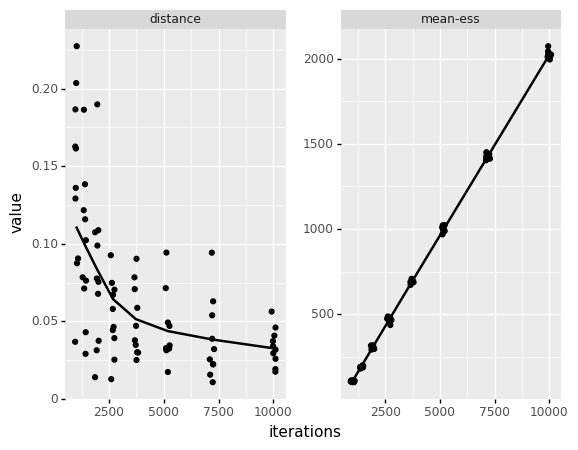

<ggplot: (8793838408461)>

In [14]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The draws trend closer to convergence as the number of iterations increases, although distance does not improve much after 5000 iterations.

Example run.

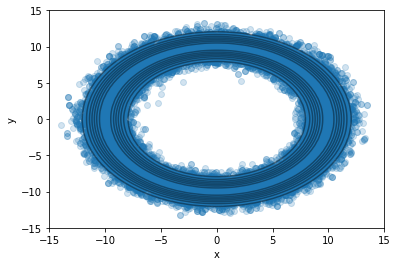

In [15]:
n_chains = 4
n_iterations = 10000
n_warmup = 500

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodal Gaussian

In [16]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.multimodal_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

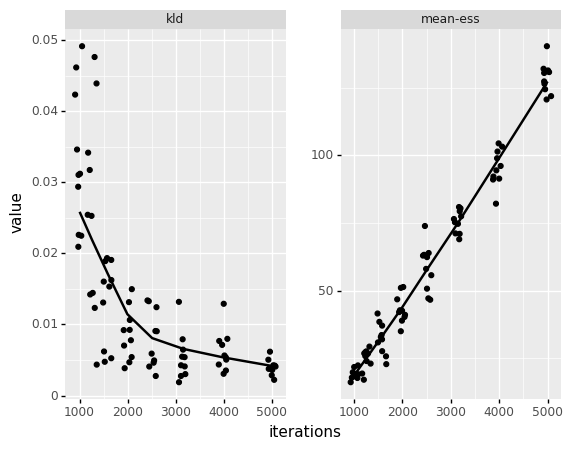

<ggplot: (8793837839038)>

In [17]:
# remove high values of kld to see general trend
test1 = test.query('kld < 0.4')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])

(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The KLD appears to be moving in the correct direction as iterations increase.

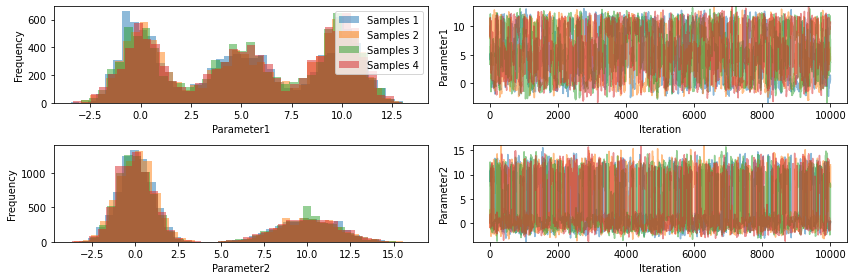

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  5.12    4.28    -1.47   0.68   5.20   9.40   11.46    1.00    717.02   5.37
param 2  3.20    4.84    -1.80   -0.37  0.62   8.62   12.47    1.00    1262.45  9.45


In [18]:
n_chains = 4
n_iterations = 10000
n_warmup = 500

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Clearly this multimodal distribution requires many draws to reach convergence.

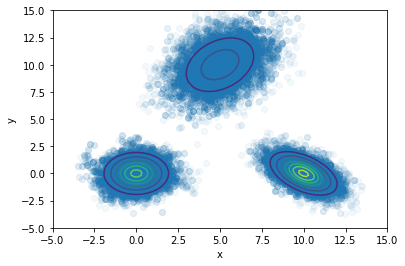

In [19]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [20]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.cone,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

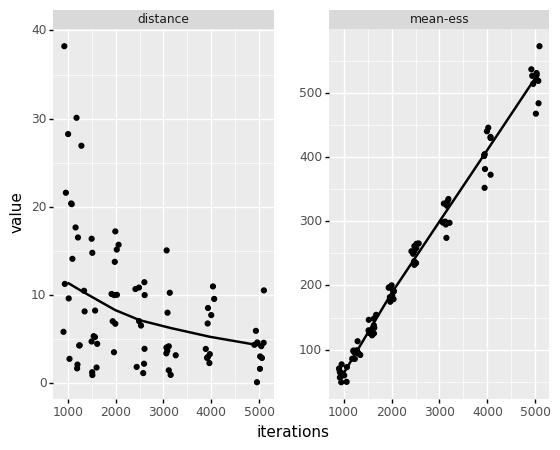

<ggplot: (8793837840957)>

In [21]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Again, the cone problem, with its long tails, is really hard. Distance does not improve much with more iterations.

Now showing an example run.

Running...
Done!
param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mean dim 1  -0.04   8.02    -17.20  -3.32  -0.04  3.33   17.10    1.00    4337.66  122.77
mean dim 2  0.12    8.11    -17.25  -3.09  0.06   3.45   17.21    1.00    4611.75  130.53


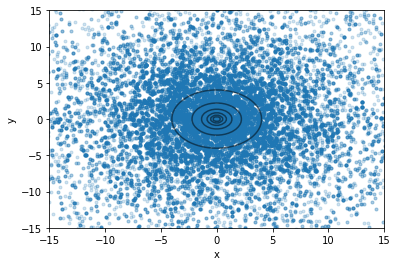

True normed mean = 8.638816024714002
Sample normed mean = 8.273760706992999
True normed var = 65.40423915068341
Sample normed var = 61.7925389552271


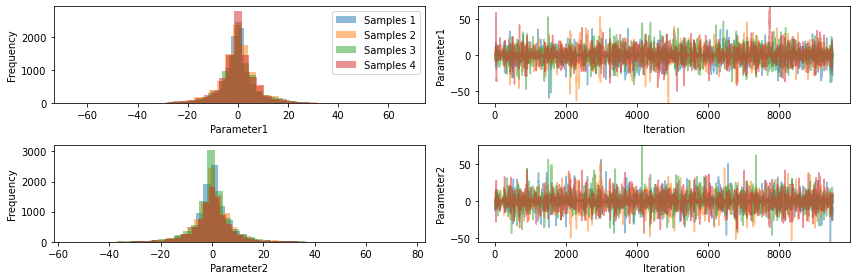

In [22]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.RelativisticMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(False)

for sampler in mcmc.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [23]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.high_dim_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/usr/local/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 66 rows containing missing values.


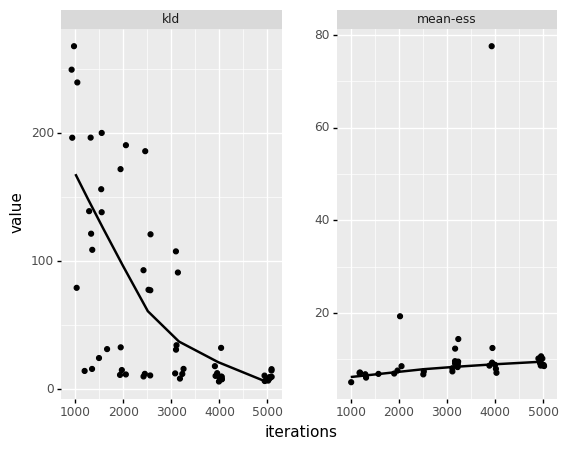

<ggplot: (8793839000378)>

In [24]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)